# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful (Postive reviews)
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not (positive+negative)
7. Score - rating between 1 and 5
8. Time - timestamp for the review (UNIX)
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.



In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# using Sqlite table to read data

con = sqlite3.connect('/content/drive/My Drive/database.sqlite')

In [0]:
# reading only postive and negative reviews i.e not
# taking into account those revoews with score=3

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score!=3
""", con)

In [0]:
# Give reviews with Score>3 a postive rating and reviews with a score<3
# a negative rating 

def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

# changing the values with score less than 3 to positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [0]:
filtered_data.shape 

(525814, 10)

In [0]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      525814 non-null  int64 
 1   ProductId               525814 non-null  object
 2   UserId                  525814 non-null  object
 3   ProfileName             525814 non-null  object
 4   HelpfulnessNumerator    525814 non-null  int64 
 5   HelpfulnessDenominator  525814 non-null  int64 
 6   Score                   525814 non-null  object
 7   Time                    525814 non-null  int64 
 8   Summary                 525814 non-null  object
 9   Text                    525814 non-null  object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


In [0]:
filtered_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

#  [Exploratory Data Analysis]

# Data Cleaning : Deduplication

It is observed that the reviews data had many duplicate entries. Hence it is necesssary to remove the duplicates in order to get unbaised results for the analysis of the data

In [0]:
# checking if there are duplicates in the data. For this we will check for
# 'UserId', 'ProfileName', 'Time', 'Text'

duplicateRowsDF = filtered_data[filtered_data.duplicated(['UserId', 'ProfileName', 'Time', 'Text'])]
duplicateRowsDF

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,positive,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
530,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,positive,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
2119,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,negative,1127606400,Below standard,Too much of the white pith on this orange peel...
2133,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,negative,1127606400,Below standard,Too much of the white pith on this orange peel...
2146,2337,B0001FQVCK,A5D06XJHDXK75,C. Po,1,1,positive,1190592000,"Baci's are pure heaven - great gift, stocking ...",My family has been in love with Baci's ever si...
...,...,...,...,...,...,...,...,...,...,...
525770,568410,B0018CLWM4,A2PE0AGWV6OPL7,Dark Water Mermaid,3,3,positive,1309651200,Quality & affordable food,I was very pleased with the ingredient quality...
525771,568411,B0018CLWM4,A88HLWDCU57WG,R28,2,2,positive,1332979200,litter box,My main reason for the five star review has to...
525772,568412,B0018CLWM4,AUX1HSY8FX55S,DAW,1,1,positive,1319500800,Happy Camper,I bought this to try on two registered Maine C...
525773,568413,B0018CLWM4,AVZ2OZ479Q9E8,Ai Ling Chow,0,0,positive,1336435200,Two Siberians like it!,When we brought home two 3-month-old purebred ...


In [0]:
# doing a sanity check if these UserId are really duplicates 
# Using the first UserId and querying for duplicates

dup_disp = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score!=3 AND UserId='A3HDKO7OW0QNK4'
ORDER BY ProductID
""", con)

dup_disp

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,506517,B0001PB9EA,A3HDKO7OW0QNK4,Canadian Fan,0,0,5,1107907200,Authentic Mexican Restaurant Taste,Just as with the Original Tequila Picante Gour...
1,195372,B0001PB9EK,A3HDKO7OW0QNK4,Canadian Fan,0,0,5,1107907200,Authentic Mexican Restaurant Taste,Just as with the Original Tequila Picante Gour...
2,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
3,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...


In the above result we can see something strange, the customer reviewed the product and the time stamp, summary and text is all the same. How is it possible? Is this an error? No.

This is related to how amazon reviews works.If see the both the products (with different IDs but similiar timestamp and summary) then we will observe that both the products are product is same but the quality (flavour or some other feature differs). So the company has given authority to amazon to use the same review for the product variations if one of them is reviewed.


But this 'Strangeness' is not good for our ML model as if I have to predict a rating on the same product variation then it will give it a positive if is positive and vice-versa which might not be the case in real life.

Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters

### Removing  the duplicates

In [0]:
# sort the data according to the ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True)

In [0]:
# dropping the duplicates (keeping the first value and dropping the rest)
deduplicated_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'},keep='first',
                                                inplace = False)
 
deduplicated_data.shape

(364173, 10)

In [0]:
# finding how much data is left after removing duplicates

(deduplicated_data.shape[0]/filtered_data.shape[0])*100.0 

69.25890143662969

In [0]:
# Checking if there are rows where HelpfulnessNumerator is greater than HelpfullnessDenominator which
# is not possible

d=zip(deduplicated_data['HelpfulnessNumerator'],deduplicated_data['HelpfulnessDenominator'])

pd.DataFrame(list(d),columns=['HelpfulnessNumerator','HelpfulnessDenominator']).query("HelpfulnessNumerator>HelpfulnessDenominator")

,HelpfulnessNumerator,HelpfulnessDenominator
103780,3,1
187617,3,2


In [0]:
# other way to do this using sql (this involves knowing the ids)

display = pd.read_sql_query("""
SELECT *
FROM Reviews 
WHERE Score!=3 AND Id=44737 OR Id=64422
ORDER BY ProductId
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


We can see that we have two rows where there is numerator>denominator so we will have to discard them

In [0]:
final_data = deduplicated_data[deduplicated_data.HelpfulnessNumerator<=deduplicated_data
                              .HelpfulnessDenominator]

In [0]:
# earlier the rows were 364173 and not it is 2 less thus we have successfully 
# removed the incorrect data

final_data.shape 

(364171, 10)

In [0]:
# How many positive and negative reviews do we have?

final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

# Bag of Words (BoW)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final_data['Text'].values)

In [0]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [0]:
final_counts.get_shape()

(364171, 115281)

# Text Preprocessing : Stemming, Stop-word removal and Lemmatization

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews to see what preprocessing is to be done

sent_0 = final_data['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

As we can clearly see that there are html tags in the reviews so let's remove them.

In [0]:
# finding sentences containing HTML tags
import re

count=0
for word in final_data['Text'].values:
    if len(re.findall('<.*?>',word)):
        print(count)
        print(word)
        break
    count+=1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [0]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')

stop = set(stopwords.words('english'))  #set of stopwords in english
sno = nltk.stem.SnowballStemmer('english')  # creating instance of Snowball Stemmer

# function to clean the word of any html-tags
def cleaned_html(sentence):
    
    # compile search string to avoid cache lookup
    cleanr = re.compile('<.*?>')
    
    # replace those occurences with blank spaces
    cleaned_text = re.sub(cleanr, ' ', sentence)
    return cleaned_text

def clean_punc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

print(stop)
print("*********************************************")
print(sno.stem("tasty"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'m', "should've", 'nor', 'don', 'both', 'from', 'all', 'while', 'she', 'doing', 'll', 'if', 'through', 'o', 'own', 'ain', 'an', 'our', 'its', 'weren', 'here', "didn't", 'be', 'his', 'about', 'more', 'a', 'won', "she's", 'will', 'does', 'such', 'below', 'into', 'these', "that'll", "don't", 'did', 'we', 'himself', "you've", 'up', 'between', 'because', 'they', 'whom', 'having', 'who', "needn't", 'few', 'during', 'him', 'can', "hadn't", 'with', "mightn't", 'wasn', 'ma', 'do', 'should', 'ours', "hasn't", 'wouldn', 'only', 'the', "you're", 'over', 'mustn', 'too', 'shouldn', 'at', 'their', "it's", 'couldn', 'didn', "haven't", 'of', 'some', 'are', 'so', 'hers', "you'd", 'yourselves', 'again', 'most', 'ourselves', 'in', 'd', 'very', 'were', 'but', 'yourself', 'then', 'themselves', "won't", 'when', 'herself', "weren't", 'have', 'there', 'hadn', "you'll", 'y', "aren't", 'was', 'to', 's'

In [0]:
# Code for implementing step by step checks mentioned in the pre-processing list above
i=0
str1=' '
final_string=[]
all_positive_words=[] # s # to store positive reviews
all_negative_words=[]  # to store negative reviews
s=''

# for each review final text
for sent in final_data['Text'].values:

    filtered_sentence=[]

    # remove HTML tags
    sent=cleaned_html(sent) 

    # split the words
    for w in sent.split():

        # remove the punctuations
        for cleaned_words in clean_punc(w).split():
            
            # check if the words are alphanumeric and more than two letters
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    

                # convert to lower case and if these words (those just filtered 
                # out in above if condn)  are not stop words
                if(cleaned_words.lower() not in stop):

                     # convert to lower then do stemming and encode them to utf-8 format
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')

                    # append the words to filtered sentence
                    filtered_sentence.append(s)

                    # if for the words, corresponding score is positive then append those to
                    # positive list else append them to negative list
                    if (final_data['Score'].values)[i] == 'positive':

                        #list of all words used to describe positive reviews 
                        all_positive_words.append(s) 
                    if(final_data['Score'].values)[i] == 'negative':

                        #list of all words used to describe negative reviews reviews
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    # final string of cleaned words
    str1 = b" ".join(filtered_sentence) 
    
    
    final_string.append(str1)
    i+=1

In [0]:
final_data["CleanedText"]= final_string
final_data["CleanedText"] = final_data["CleanedText"].str.decode("utf8")

In [0]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [0]:
conn = sqlite3.connect('final_data.sqlite')
c = conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn, schema= None, if_exists = 'replace')

In [0]:
con = sqlite3.connect('/content/final_data.sqlite')

In [0]:
final_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""",con)

In [0]:
final_data.shape

(364171, 12)

# Bi-Grams and n-Grams

### Motivation

Now that we have our list of words describing positive and negative reviews lets analyse them.

We begin the analysis by getting the frequency distribution of the words as show below

In [0]:
freq_dist_positive = nltk.FreqDist(all_positive_words)
freq_dist_negative = nltk.FreqDist(all_negative_words)
print("Most common Positive Words :" ,freq_dist_positive.most_common(20))
print("*******************************************************************")
print("Most common negative words:" ,freq_dist_negative.most_common(20))

Most common Positive Words : [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
*******************************************************************
Most common negative words: [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


### Observation

From above it can be seen that the most common positive and negative words overlap for eg. 'like' could be used as 'not like' etc.

So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequence of n consecutive words (n-grams)

In [0]:
# bi-gram, tri-gram and n-gram

# removing stop words like "not" should be avoided before building n-grams 

# ngram range here specifies unigrams and bigrams 
count_vect = CountVectorizer(ngram_range = (1,2))

# Learn the vocabulary dictionary and return term-document matrix.
final_bigram_counts = count_vect.fit_transform(final_data['Text'].values)

In [0]:
final_bigram_counts.get_shape()

(364171, 2910192)

# TF-IDF

In [0]:
# tfidfVectorizer = CountVectorizer + TfidfTransformer

from sklearn.feature_extraction.text import TfidfVectorizer

# ngram range here specifies unigrams and bigrams 
tf_idf_vector = TfidfVectorizer(ngram_range=(1,2))

# Learn vocabulary and idf, return term-document matrix.
final_tf_idf = tf_idf_vector.fit_transform(final_data['Text'].values)

In [0]:
final_tf_idf.get_shape()

(364171, 2910192)

In [0]:
# Array mapping from feature integer indices to feature name.
features = tf_idf_vector.get_feature_names()
len(features)

2910192

In [0]:
# mixture of bigrams and unigrams

features[100000:100010]

['ales until',
 'ales ve',
 'ales would',
 'ales you',
 'alessandra',
 'alessandra ambrosia',
 'alessi',
 'alessi added',
 'alessi also',
 'alessi and']

In [0]:
# convert a row in sparsematrix to a numpy array

print(final_tf_idf[3,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [0]:
# get top n tfidf values in row and return them with their corresponding ranks

def top_tfidf_feats(row, features, top_n=25):
    
    # sorting the rows and then taking the last 25 values
    topn_ids = np.argsort(row)[::-1][:top_n]
    
    # making a list of tuples of top 25 features and their tfidfs
    top_feats = [(features[i],row[i]) for i in topn_ids]
    
    # coverting it to a data frame
    df = pd.DataFrame(top_feats)
    
    # given columns the name feature and tfidf
    df.columns = ['feature', 'tfidf']
    
    return df


top_tfidf = top_tfidf_feats(final_tf_idf[1, :].toarray()[0],features,25)

 

In [0]:
top_tfidf

,feature,tfidf
0,sendak books,0.173437
1,rosie movie,0.173437
2,paperbacks seem,0.173437
3,cover version,0.173437
4,these sendak,0.173437
5,the paperbacks,0.173437
6,pages open,0.173437
7,really rosie,0.168074
8,incorporates them,0.168074
9,paperbacks,0.168074


# Word2Vec

In [0]:
# Training our W2V model using our text corpus

import gensim

# creating a list of list of sentences
i=0
list_of_sent=[]
for sent in final_data['Text'].values:
    filtered_Sentence = []
    sent = cleaned_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punc(w).split():
            if cleaned_words.isalpha():
                filtered_Sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_Sentence)

In [0]:
print(final_data['Text'].values[0])
print("******************************************************")
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
******************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'co

In [0]:
# training the Word2Vec model

# min_count = threshold for count needed for converting to a vector
# size = dimensionality of vector
# workers = number of cores to be used
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)

In [0]:
words = list(w2v_model.wv.vocab)
print(len(words))

33783


In [0]:
# finding most similiar words to 'tasty' using our corpus

w2v_model.wv.most_similar('tasty')

[('tastey', 0.9224304556846619),
 ('satisfying', 0.8562636971473694),
 ('yummy', 0.8534162044525146),
 ('filling', 0.8199149370193481),
 ('delicious', 0.8191810846328735),
 ('flavorful', 0.798619270324707),
 ('addicting', 0.7756116986274719),
 ('versatile', 0.7651001214981079),
 ('delish', 0.7604049444198608),
 ('tasteful', 0.7587823867797852)]

In [0]:
# finding most similiar words to 'like' using our corpus

w2v_model.wv.most_similar('like')

[('resemble', 0.7107076048851013),
 ('dislike', 0.6501305103302002),
 ('mean', 0.646845817565918),
 ('prefer', 0.6406247019767761),
 ('think', 0.6100004315376282),
 ('clash', 0.6060815453529358),
 ('enjoy', 0.5876287817955017),
 ('overwhelm', 0.5872810482978821),
 ('fake', 0.5741391777992249),
 ('overpower', 0.5710858106613159)]

In [0]:
# name of word in the BoW reperesentation
count_vect_feat = count_vect.get_feature_names()

# what is the index of word 'like'
count_vect_feat.index('like')

1442686

In [0]:
print(count_vect_feat[1442686])

like


# Avg W2V, TFIDF-W2V


In [0]:
# average W2V
# compute average Word2Vec for each review.

# the avg-w2v for each sentence/review will be stored in this list
sent_vectors = []

# for each review/sentence
for sent in list_of_sent:
    
    # initialise sent_vec with zeroes (50 is the dimensionality
    # of feature vectors)
    sent_vec = np.zeros(50)
    
    # number of words with a valid vector in the sentence/review 
    cnt_words = 0
    
    # for each word in review/sentence
    for word in sent:
        
        if word in words:
            
            # computing vector using w2v model
            vec = w2v_model.wv[word]
            
            # add those vectors to sentence vector
            sent_vec+=vec
            
            # increase the count
            cnt_words +=1
            
    if cnt_words!=0:
      # calculate average
      sent_vec/= cnt_words

    # appending the vectors to a final list 
    sent_vectors.append(sent_vec)
        
print(len(sent_vectors))
print(len(sent_vectors[0]))

364171
50


In [0]:
# TF-IDF weighted Word2Vec

# tf-idf words/col-names
tfidf_feat = tf_idf_vector.get_feature_names()


# final_tf_idf is the sparse matrix with row = sentence, col=word and cell_values
# as tfidf

# the tfidf-w2v for each sentence/review is stored in this list
tfidf_sent_vectors = []
row = 0

# for each review/sentence
for sent in list_of_sent:
    
    # as words vectors are of zero length
    sent_vec = np.zeros(50)
    
    # num of words with a valid vector in the sentence/review
    weight_sum = 0
    
    # for each word in review/sentence
    for word in sent:
        try:
            vec = w2v_model.wv[word]
     
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass

    # checking if the sum is 0 or not as this might result inn
    # nan or infinite values in the vectors
    if weight_sum!=0:
      sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

# Applying TSNE


<ol> 
    <li> We will plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li><br>
    <li>Note 1: The TSNE accepts only dense matrices</font></li>
    <li>Note 2: We have considered only 2k-5k data points for computational reasons.</font></li>
</ol>

### Applying TNSE on Text BoW vectors


In [0]:
from sklearn.manifold import TSNE

In [0]:
# Applying TSNE on BoW

data_2000 = final_counts[0:2000,:].todense()
labels_2000 = final_data["Score"][0:2000]

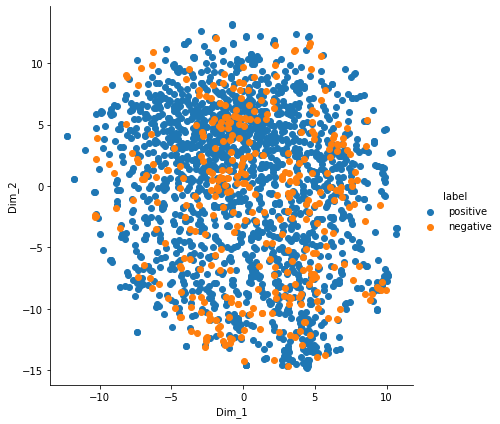

In [0]:
# training our TSNE model


# number of components given = 2 as we want 2D visualisation
# perplexity = 50 
# learning rate = 200 (default)
# number of iterations = 2000
model = TSNE(n_components=2, random_state=2, perplexity=50, n_iter=2000)

# learning the model and applying it to the data
tsne_data = model.fit_transform(data_2000)

# creating a new data for plotting the resultant data by stacking
# the data and labels together vertically
tsne_data = np.vstack((tsne_data.T, labels_2000)).T

# coverting it to dataframe
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))

# Plotting the result using tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()

plt.show()

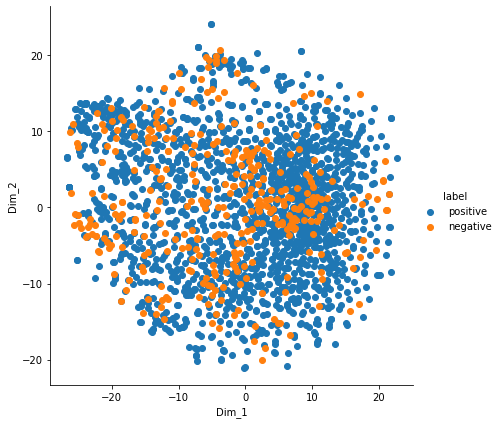

In [0]:
# training our TSNE model


# number of components given = 2 as we want 2D visualisation
# perplexity = 30
# learning rate = 200 (default)
# number of iterations = 1000
model = TSNE(n_components=2, random_state=0)

# learning the model and applying it to the data
tsne_data = model.fit_transform(data_2000)

# creating a new data for plotting the resultant data by stacking
# the data and labels together vertically
tsne_data = np.vstack((tsne_data.T, labels_2000)).T

# coverting it to dataframe
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))

# Plotting the result using tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()

plt.show()

In [0]:
# Applying TSNE on TFIDF

data_5000 = final_tf_idf[0:5000,]
labels_5000 = final_data["Score"][0:5000]

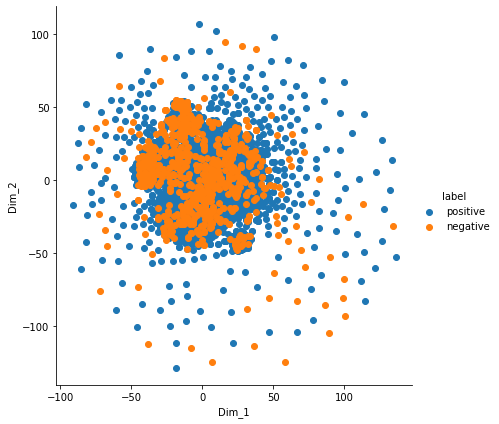

In [0]:
# training our TSNE model


# number of components given = 2 as we want 2D visualisation
# perplexity = 50 
# learning rate = 200 (default)
# number of iterations = 2000
model = TSNE(n_components=2, random_state=2, perplexity=50, n_iter=2000)

# learning the model and applying it to the data
tsne_data = model.fit_transform(data_5000)

# creating a new data for plotting the resultant data by stacking
# the data and labels together vertically
tsne_data = np.vstack((tsne_data.T, labels_5000)).T

# coverting it to dataframe
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))

# Plotting the result using tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()

plt.show()

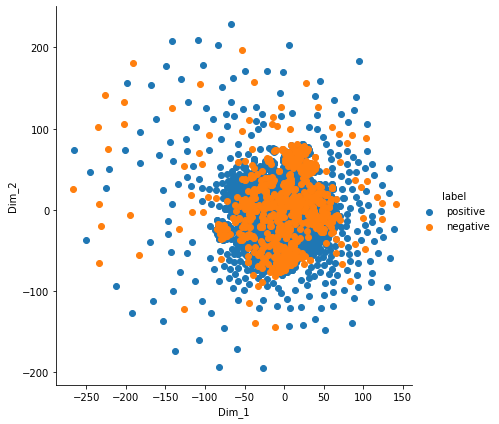

In [0]:
# training our TSNE model


# number of components given = 2 as we want 2D visualisation
# perplexity = 30 (default)
# learning rate = 200 (default)
# number of iterations = 5000
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)

# learning the model and applying it to the data
tsne_data = model.fit_transform(data_5000)

# creating a new data for plotting the resultant data by stacking
# the data and labels together vertically
tsne_data = np.vstack((tsne_data.T, labels_5000)).T

# coverting it to dataframe
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))

# Plotting the result using tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()

plt.show()

In [0]:
# Applying TSNE on Average Word2Vec

data_5000 = sent_vectors[0:5000]
labels_5000 = final_data["Score"][0:5000]

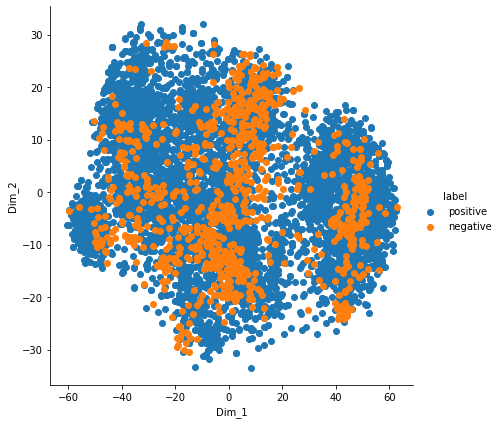

In [0]:
# training our TSNE model


# number of components given = 2 as we want 2D visualisation
# perplexity = 50 
# learning rate = 200 (default)
# number of iterations = 2000
model = TSNE(n_components=2, random_state=2, perplexity=50, n_iter=2000)

# learning the model and applying it to the data
tsne_data = model.fit_transform(data_5000)

# creating a new data for plotting the resultant data by stacking
# the data and labels together vertically
tsne_data = np.vstack((tsne_data.T, labels_5000)).T

# coverting it to dataframe
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))

# Plotting the result using tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()

plt.show()

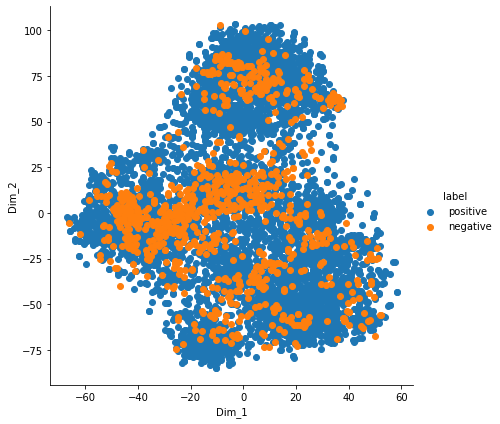

In [0]:
# training our TSNE model


# number of components given = 2 as we want 2D visualisation
# perplexity = 30 
# learning rate = 200 (default)
# number of iterations = 5000
model = TSNE(n_components=2, random_state=0, n_iter=5000)

# learning the model and applying it to the data
tsne_data = model.fit_transform(data_5000)

# creating a new data for plotting the resultant data by stacking
# the data and labels together vertically
tsne_data = np.vstack((tsne_data.T, labels_5000)).T

# coverting it to dataframe
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))

# Plotting the result using tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()

plt.show()

In [0]:
# Applying TSNE on TFIDF Word2Vec

data_5000= tfidf_sent_vectors[0:5000]
labels_5000 = final_data["Score"][0:5000]

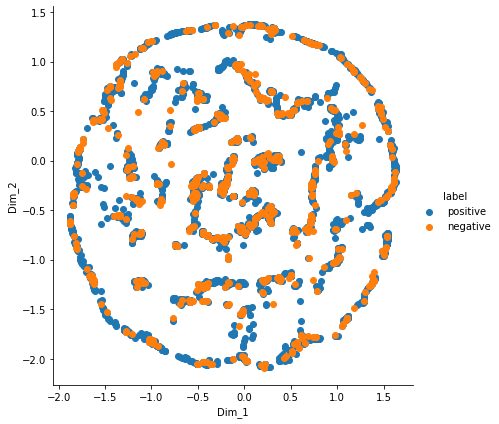

In [0]:
# training our TSNE model


# number of components given = 2 as we want 2D visualisation
# perplexity = 30 
# learning rate = 200 (default)
# number of iterations = 1000
model = TSNE(n_components=2, random_state=0)

# learning the model and applying it to the data
tsne_data = model.fit_transform(data_5000)

# creating a new data for plotting the resultant data by stacking
# the data and labels together vertically
tsne_data = np.vstack((tsne_data.T, labels_5000)).T

# coverting it to dataframe
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))

# Plotting the result using tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()

plt.show()

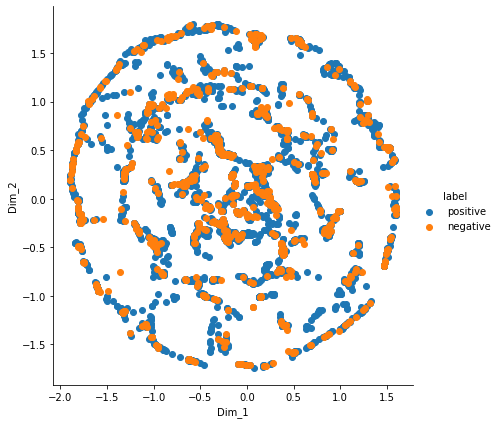

In [0]:
# training our TSNE model


# number of components given = 2 as we want 2D visualisation
# perplexity = 50 
# learning rate = 200 (default)
# number of iterations = 5000
model = TSNE(n_components=2, random_state=2, perplexity=50, n_iter=5000)

# learning the model and applying it to the data
tsne_data = model.fit_transform(data_5000)

# creating a new data for plotting the resultant data by stacking
# the data and labels together vertically
tsne_data = np.vstack((tsne_data.T, labels_5000)).T

# coverting it to dataframe
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))

# Plotting the result using tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()

plt.show()

# Observations

### Bag of Words Model
We can clearly observe that using t-sne on Bag of Words model with 2K points, the plot of both the class label are not seperable and even on varying the perplexity and other hyperparameters, the result was the same. <br>

### Term Frequency- Inverse Document Frequency (TF-IDF) Model
When plotting t-sne for TF-IDF model using 5k points, we observe that the plot is not too much dense as compared to the BoW model but still the two classes (positive and negative) are too much overlapped and hence cannot be seperated. <br>
Another obeservation here was that when we decrease the perplexity and number of iterations then the cluster shifts to the right and some points are scattered on the left of the cluster.

### Average Word2Vector Model
When plotting t-sne for Average W2V model using 5k points we observed that there is almost 80%-85% overlapping and it is very difficult to draw a line to classify the polarity of the reviews.
 The blue points and orange point i.e both the classes overlap all the time and even on changing the perplexity, the result was similiar. Hence using this model as well, both the classes cannot be seperated.

### Weighted Word2Vec model
When plotting t-sne for Average W2V model using 5k points we observed that the points are overlapping and we get a ball like shape.

As a final conclusion, we can deduce that both the classes are important and cannot be seperated from each other.

